<a href="https://colab.research.google.com/github/bonvech/MSU-AI/blob/main/Copy_of_L10_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">Трансформеры</font>

Порождение выходной последовательности по входной находит применение во многих областях машинного обучения: от обработки естественного языка до генерации описаний объектов на фотографиях.

До недавнего времени наиболее эффективные seq2seq-модели основывались на сложных рекуррентных или сверточных нейронных сетях, беря за основу подход encoder-decoder и механизм внимания. В 2017 году в статье [«Attention Is All You Need» 🎓[arxiv]](https://arxiv.org/abs/1706.03762) была предложена новая архитектура, основанная исключительно на механизмах внимания, названная Transformer.

# Классический seq2seq

В простейшем варианте модель seq2seq представляет собой две последовательно соединенные рекуррентные сети: **Encoder** и **Decoder**. Encoder принимает на вход последовательность векторных представлений токенов и генерирует **hidden state**, который подается на вход Decoder’а. Decoder, в свою очередь, служит для построения целевой последовательности по внутреннему состоянию.

На примере задачи перевода: на вход кодировщику подается текст на исходном языке. Тогда hidden state можно интерпретировать как смысл этого текста, по которому затем декодировщик восстанавливает текст на целевом языке.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/seq_to_seq_with_rnn.png" width="1000"></center>

Было бы здорово так кодировать данные, чтобы сжатые представления на английском языке были близки к сжатым представлениями на русском.

А ещё хорошо бы добиться того, чтобы сжатые представления перестали быть равнозначными. Чтобы учитывались контекст, окружающие слова. Так, для слова "мы" гораздо важнее "we", нежели "bread".

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/attention_vector.png" width="700"></center>

Кроме того, вектор фиксированного размера $h_N$ — бутылочное горлышко сети.

**Идея:** поставить нейросеть поверх $h_1 ... h_4$, чтобы вектор в декодер шёл как взвешенная комбинация векторов.

# Cross-Attention

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/cross_attention.png" width="700"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Lena Voita</a></em></center>

Концепция **attention** состоит в предположении, что между токенами существуют некоторые взаимосвязи. При таком подходе кодировщик передает в декодировщик не одно состояние, кодирующее всю последовательность целиком, а взвешенный набор состояний всех токенов.

## RNN + Cross-Attention

В прошлой лекции мы работали с RNN без внимания. С помощью механизма внимания в конце этого блока мы получим примерно следующее:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/cross_attention_with_rnn.png" width="700"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Lena Voita</a></em></center>

Материал на основе [официальной документации PyTorch 🛠️[doc]](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

### Подготовка данных

Нам понадобится уникальный индекс для каждого слова, чтобы позже использовать его в качестве входных данных и таргетов. Сделаем вспомогательный класс Lang из словарей **слово → индекс** (`word2index`) **и индекс → слово** (`index2word`), а также счетчик каждого слова `word2count`, который будет использоваться для замены редких слов позже.

In [ ]:
from IPython.display import clear_output

!pip install -q -U transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q sentencepiece sentence_transformers
!pip install -q -U datasets huggingface-hub
clear_output()

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Все файлы представлены в формате Unicode, поэтому для упрощения мы преобразуем символы Unicode в ASCII, сделаем все строчными и уберём большую часть знаков препинания.

In [ ]:
import re
import unicodedata


def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()


def normalizeStringRu(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-яА-Я!?]+", r" ", s)
    return s.strip()

Делим файл на строки, а строки — на пары.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/eng_rus_vocab.txt

In [ ]:
from io import open


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = (
        open("%s_%s_vocab.txt" % (lang1, lang2), encoding="utf-8")
        .read()
        .strip()
        .split("\n")
    )

    # Split every line into pairs and normalize
    pairs = [l.split("\t")[:2] for l in lines]
    eng = [normalizeString(s[0]) for s in pairs]
    rus = [normalizeStringRu(s[1]) for s in pairs]
    pairs = list(zip(rus, eng))

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Для скорости сократим датасет до предложений не длинее 10 слов и отфильтруем апострофы.

In [ ]:
max_length = 10

eng_prefixes = (
    "i am ",
    "i m ",
    "he is",
    "he s ",
    "she is",
    "she s ",
    "you are",
    "you re ",
    "we are",
    "we re ",
    "they are",
    "they re ",
)


def filterPair(p):
    return (
        len(p[0].split(" ")) < max_length
        and len(p[1].split(" ")) < max_length
        and p[1].startswith(eng_prefixes)
    )


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
import random


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData("eng", "rus", False)
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
Trimmed to 30724 sentence pairs
Counting words...
Counted words:
eng 10510
rus 4349
('я в общем то не занят', 'i m not really busy')


### Кодировщик-декодировщик

In [ ]:
import torch.nn as nn


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

На каждом этапе декодирования декодеру предоставляются входной токен и скрытое состояние. Начальный входной токен — токен начала строки <SOS>, первое скрытое состояние — вектор контекста (последнее скрытое состояние кодировщика).

In [ ]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device
        ).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(max_length):
            decoder_output, decoder_hidden = self.forward_step(
                decoder_input, decoder_hidden
            )
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(
                    -1
                ).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return (
            decoder_outputs,
            decoder_hidden,
            None,
        )  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Слой Attention

Сначала мы вычисляем **набор весов Attention**. Они будут умножены на выходные векторы энкодера для создания взвешенной комбинации. Результат должен содержать информацию об этой конкретной части входной последовательности и помогать декодеру выбирать правильные выходные слова.

Вычисление весов Attention выполняется с помощью линейного слоя. В данных присутствуют предложения всех размеров, и для фактического создания и обучения этого слоя нужно выбрать максимальную длину предложения. В предложениях максимальной длины будут использоваться все веса внимания, в то время как в более коротких предложениях будут использоваться только первые несколько.

Механизм **аддитивного внимания** реализован в:

[[arxiv] 🎓 Neural Machine Translation by Jointly Learning to Align and Translate (Bandanau et al., 2016)](https://arxiv.org/abs/1409.0473)

$\large a(h, h') = \color{red}{w}^Tth(\color{red}{U}h + \color{red}{V}h')$ — аддитивное внимание с $\color{red}{w, U, V}$.

В оригинальной статье вектора $h$ и $h'$ конкатенируются, т.е. операция выше представляется как:

$\large a(h, h') = \color{red}{w}^Tth(\color{red}{\Omega}[h;h'])$

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device
        ).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(max_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(
                    -1
                ).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Подготовка к обучению

**Подготовка данных**

Для обучения для каждой пары нам понадобятся входной тензор (индексы слов во входном предложении) и целевой тензор (индексы слов в целевом предложении). При создании этих векторов мы добавим токен EOS к обеим последовательностям.

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(1, -1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def get_dataloaders(batch_size):
    input_lang, output_lang, pairs = prepareData("eng", "rus", False)

    n = len(pairs)
    input_ids = np.zeros((n, max_length), dtype=np.int32)
    target_ids = np.zeros((n, max_length), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, : len(inp_ids)] = inp_ids
        target_ids[idx, : len(tgt_ids)] = tgt_ids

    # prepare train/va/test split of sentance pairs
    all_pairs_idx = np.random.permutation(len(input_ids))
    train_len = int(0.8 * len(input_ids))
    val_len = int(0.15 * len(input_ids))
    train_pairs, val_pairs, test_pairs = np.split(
        ary=all_pairs_idx, indices_or_sections=[train_len, train_len + val_len]
    )

    # prepaer datasets
    datasets = {}
    for split, pair_ids in zip(
        ["train", "val", "test"], [train_pairs, val_pairs, test_pairs]
    ):
        datasets[split] = TensorDataset(
            torch.LongTensor(input_ids[pair_ids, ...]),
            torch.LongTensor(target_ids[pair_ids, ...]),
        )
    # prepare dataloaders
    train_dataloader = DataLoader(
        datasets["train"], batch_size=batch_size, shuffle=True
    )

    val_dataloader = DataLoader(datasets["val"], batch_size=batch_size, shuffle=False)

    test_dataloader = DataLoader(datasets["test"], batch_size=batch_size, shuffle=False)
    return (
        input_lang,
        output_lang,
        train_dataloader,
        val_dataloader,
        test_dataloader,
        test_pairs,
    )

**Обучение модели**

Для обучения мы пропускаем предложение через кодировщик и отслеживаем каждый выход и последнее скрытое состояние. Затем декодер получает токен <SOS> в качестве первого входа и последнее скрытое состояние кодировщика в качестве первого скрытого состояния.

In [ ]:
! pip install -q lightning tbparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 23.8 MB/s eta 0:00:00


In [ ]:
import lightning as L
from itertools import chain


class Seq2SeqPipeline(L.LightningModule):
    def __init__(
        self,
        encoder,
        decoder,
        exp_name="baseline",
        criterion=nn.NLLLoss(),
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.criterion = criterion

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            chain(self.encoder.parameters(), self.decoder.parameters()), lr=0.001
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        input_tensor, target_tensor = batch

        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, _, _ = self.decoder(
            encoder_outputs, encoder_hidden, target_tensor
        )

        loss = self.criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1)
        )

        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_tensor, target_tensor = batch

        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, _, _ = self.decoder(
            encoder_outputs, encoder_hidden, target_tensor
        )

        loss = self.criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1)
        )

        self.log("Loss/val", loss, prog_bar=True)

**Процесс обучения**:

In [ ]:
hidden_size = 512
batch_size = 256

(
    input_lang,
    output_lang,
    train_dataloader,
    val_dataloader,
    test_dataloader,
    test_pair_ids,
) = get_dataloaders(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

Reading lines...
Read 496059 sentence pairs
Trimmed to 30724 sentence pairs
Counting words...
Counted words:
eng 10510
rus 4349


In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger


L.seed_everything(42)

checkpoint_callback = ModelCheckpoint(monitor="Loss/val", mode="min", filename="best")

exp_name = f"baseline"
trainer = Trainer(
    max_epochs=80,
    logger=TensorBoardLogger(save_dir=f"logs/seq2seq", name=exp_name),
    num_sanity_val_steps=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=5,
)


pipeline = Seq2SeqPipeline(encoder=encoder, decoder=decoder)

trainer.fit(
    model=pipeline,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params
---------------------------------------------
0 | encoder   | EncoderRNN     | 7.0 M 
1 | decoder   | AttnDecoderRNN | 7.3 M 
2 | criterion | NLLLoss        | 0     
---------------------------------------------
14.3 M    Trainable params
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=80` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.


Визуализация процесса обучения:

In [ ]:
from tbparse import SummaryReader
import matplotlib.pyplot as plt


def tbparse_visual(log_path):
    reader = SummaryReader(log_path)
    df = reader.scalars

    plt.figure(figsize=(12, 4))
    for tag in df.tag.unique():
        if "Loss" in tag:
            tag_data = df.query("`tag` == @tag").sort_values(by="step")
            tag_data = tag_data.value.values
            plt.plot(tag_data, label=tag)
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend()
    plt.grid()
    plt.show()

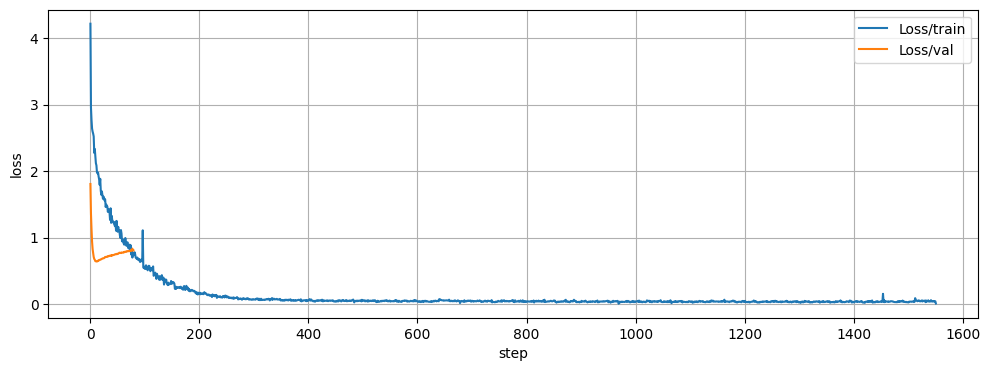

In [ ]:
import os

base_path = f"/content/logs/seq2seq/{exp_name}"
last_version = sorted(os.listdir(base_path))[-1]
log_path = f"{base_path}/{last_version}"

tbparse_visual(log_path)

Восстановим модели из лучшей контрольной точки:

In [ ]:
ckpt_path = f"{log_path}/checkpoints/best.ckpt"
checkpoint = torch.load(ckpt_path, map_location=device)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict_encoder = {}
state_dict_decoder = {}
for key in checkpoint["state_dict"].keys():
    if key.startswith("encoder."):
        state_dict_encoder[key[len("encoder.") :]] = checkpoint["state_dict"][key]
    elif key.startswith("decoder."):
        state_dict_decoder[key[len("decoder.") :]] = checkpoint["state_dict"][key]

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

encoder.load_state_dict(state_dict_encoder)
decoder.load_state_dict(state_dict_decoder)

Checkpoint has been loaded from /content/logs/seq2seq/baseline/version_0/checkpoints/best.ckpt
Best model has been saved on the 11 epoch


<All keys matched successfully>

**Тестирование**

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor.to(device))
        decoder_outputs, decoder_hidden, decoder_attn = decoder(
            encoder_outputs.to(device), encoder_hidden.to(device)
        )

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Мы можем оценить случайные предложения из обучающего набора:

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    eng = []
    dnn = []
    for i in range(n):
        pair_id = random.choice(test_pair_ids)
        pair = pairs[pair_id]
        print("RUS", pair[0])
        print("ENG", pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        eng.append(pair[1])
        dnn.append(output_words[:-1])  # remove <eos> token
        output_sentence = " ".join(output_words)
        output_sentence = " ".join(output_words)
        print("DNN", output_sentence)
        print("")
    return eng, dnn

### Обучение и тестирование

In [ ]:
encoder.eval()
decoder.eval()
eng, dnn = evaluateRandomly(encoder, decoder)

RUS я не такои тупои
ENG i m not that dumb
DNN i m not stupid <EOS>

RUS я жду ответа на свои вопросы
ENG i m waiting for an answer to my questions
DNN i m waiting for your answer <EOS>

RUS я не собираюсь извиняться
ENG i m not going to apologize
DNN i m not going to apologize <EOS>

RUS я не привык это делать
ENG i m not used to doing this
DNN i m not used to doing this <EOS>

RUS я пастух
ENG i m a shepherd
DNN i m hurt <EOS>

RUS я старше тома
ENG i m older than tom
DNN i m older than tom <EOS>

RUS вы спать хотите так идите ложитесь
ENG you re sleepy so go to bed
DNN you re sleepy so much of trouble so long <EOS>

RUS я очень расстроена
ENG i m very upset
DNN i m very upset <EOS>

RUS я собираюсь вернуться домои в бостон
ENG i m going back home to boston
DNN i m going to go back to boston <EOS>

RUS я слишком устала чтобы бегать
ENG i m too tired to run
DNN i am too tired to run <EOS>



### Визуализация Attention

input = я рад что у тебя все получилось
output = i m glad you succeeded <EOS>


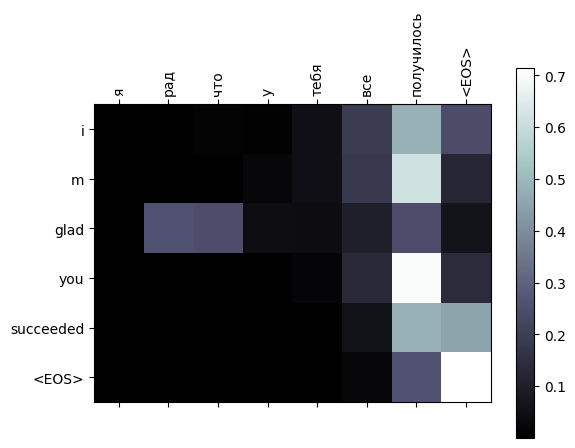

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap="bone")
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticks(ax.get_yticks().tolist()[1:-1])
    ax.set_xticks(ax.get_xticks().tolist()[1:-1])

    ax.set_xticklabels(input_sentence.split(" ") + ["<EOS>"], rotation=90)
    ax.set_yticklabels(output_words)
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence, input_lang, output_lang
    )
    print("input =", input_sentence)
    print("output =", " ".join(output_words))
    showAttention(input_sentence, output_words, attentions[0, : len(output_words), :])


evaluateAndShowAttention("я рад что у тебя все получилось")

**BLEU**

In [ ]:
from torchtext.data.metrics import bleu_score

eng_for_bleu = [[x.split()] for x in eng]
bleu = bleu_score(dnn, eng_for_bleu)
print(round(bleu, 2))

0.6


## Разновидности функций сходства


$\large a(h, h') = h^Th'$ — скалярное произведение (векторы близких слов практически параллельны);

$\large a(h, h') = \mu * \exp(h^Th')$ — возможны степенные операции, добавление домножения на константу;

$\large a(h, h') = h^T\color{red}{W}h'$ — c матрицей обучаемых параметров $\color{red}{W}$;

$\large a(h, h') = \color{red}{w}^Tth(\color{red}{U}h + \color{red}{V}h')$ — аддитивное внимание с $\color{red}{w, U, V}$.



Вводя внимание, мы говорили о некоторой **функции сходства** между **текущим** скрытым состоянием декодировщика $h'$ и **всеми** скрытыми состояниями кодировщика $h$. Обобщением механизма внимания является введение  **обучаемых параметров**.

Какие вообще бывают функции сходства?


1.   Первое, что приходит в голову, — просто считать скалярное произведение $h$ и $h'$.
2.   Также можно использовать степенную функцию или умножение на константу.

Первые два способа возможны, только если потребовать, чтобы $h$ и $h'$ имели одинаковую размерность.

3.   Можно вводить матрицу обучаемых параметров $W$.
4.   Можно вводить небольшую двухслойную нейронную сеть с несколькими весовыми матрицами. Такое введение функции сходства называется аддитивным вниманием.



### Key, Query, Value


Часто используемым подходом является введение трех типов векторов, которые называют **Query**, **Key** и **Value**.

$q$ — вектор-запрос, для которого хотим вычислить контекст [декодировщик]

$K = (k_1,..., k_n)$ — векторы-ключи, сравниваемые с запросом [кодировщик]

$V = (v_1,..., v_n)$ — векторы-значения, образующие контекст [кодировщик]









**Рассмотрим задачу перевода**

Я видел мохнатого котю на лежанке. $\longrightarrow$ I saw furry **cat** on the bed.

* query: cat

* K: ['Я', 'видел', 'мохнатого', 'котю', 'на', 'лежанке', '.'] $\rightarrow$ ['0', '0', '0.2', '0.8', '0', '0', '0']

* V: ['Я', 'видел', 'мохнатого', 'котю', 'на', 'лежанке', '.'] $\rightarrow$ ['Я', 'видел', <font color='coral'>'мохнатого'</font>, <font color='darkred'>'котю'</font>, 'на', 'мате', '.']

**Иными словами**:


$\large c = \text{Attn}(q, K, V) =  \Sigma_i v_{i} \text{SoftMax}(a(k_i, q)),$

где $a(k_i,q)$ — оценка сходства ключа $k_i$ запросу $q$.

$\large \text{Attn}(Q, K, V) =  \text{SoftMax}(\dfrac{QK^{T}}{\sqrt{d_K}})V$ — на практике Attention вычисляется для набора запросов, сформированных в матрицу $Q$. Таким образом мы переходим к матричной форме записи.


**Линейные преобразования векторов** **Query**, **Key** и **Value**.

Для каждого типа вектора вводится свое линейное преобразование, которое из исходного вектора делает вектор в каком-то другом пространстве. Все три они обычно приводятся к одной и той же размерности, обозначенной $d$.

<div align="center">
    <table >
     <tr>
       <td>
       
$$\large a(h_i, h^\prime_{t-1}) = (\color{red}{W_k}h_i)^T(\color{red}{W_q}h^\prime_{t-1}) / \sqrt d$$

$$\large \alpha_{ti} = \text{SoftMax} \space a(h_i, h^\prime_{t-1})$$

$$\large c_t = \Sigma_i \alpha_{ti} \color{red}{W_v} h_i$$

$$ \sum_{i=1}^{N}a_{ti} = 1,$$

$$  0\leqslant a_{ti} \leqslant 1.$$

$ \large \color{red}{W_q}_{d \times dim(h^\prime)}, \color{red}{W_k}_{d \times dim(h)}, \color{red}{W_v}_{d \times dim(h)}$ — матрицы

весов Query, Key, Value, линейные слои в пространстве

 размерности $\large d$).


Возможно упрощение модели: $\large \color{red}{W_k} \equiv \color{red}{W_v}$
       
</td>
<td>
<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/query_key_value.png" width="250">

<center><em>Source: <a href="http://www.machinelearning.ru/wiki/images/1/19/Voron-ML-Attention-slides.pdf">Обработка последовательностей: модели внимания и трансформеры</a></em></center>
        </td>
     </tr>
    </table>
    </div>

# Self-Attention

Чтобы избавиться от вычислительно неповоротливых RNN, пошли дальше и добавили в кодировщик механизм т.н. самовнимания **"Self-Attention"**.

Каждое слово идет по своей собственной траектории в энкодере. И, хотя существуют зависимости между этими траекториями в слоях самовнимания, в слое сети прямого распространения таких зависимостей нет, что позволяет различным траекториям выполняться параллельно во время прохождения через сеть.

**Self-Attention** – ключевая идея модели Transformer, позволяющая находить связи между словами в предложении (или объектами в слое).


<div align="center">
    <table >
     <tr>
        <td><b style="font-size:60px">
        
Attention</b>
        </td>
        <td><b style="font-size:60px">
        
Self-attention</b></td>
     </tr>
     <tr>
       <td>

**Откуда:** из одного текущего состояния декодера

**Куда:** во все состояния кодировщика
       </td>
      <td>

**Откуда:** из каждого состояния в слое

**Куда:** во все состояния в том же слое
        </td>
     </tr>
    </table>
    </div>



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/encoder_self_attention.gif" width="600"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Lena Voita NLP Course</a></em></center>

[[colab] 🥨 Интерактивный блокнот для визуализации Self-Attention](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing)

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/qkv_explained.png" width="700"></center>

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/qkv_attention_formula.png" width="400"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Lena Voita NLP Course</a></em></center>

## Архитектура сети Transformer

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/transformer_architecture.png" width="450"></center>

<center><em>Архитектура трансформера</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1706.03762.pdf"> Attention Is All You Need</a></em></center>

Архитектура, построенная целиком на механизме внимания, без свёрток и рекуррентных блоков, изначально была создана для задачи машинного перевода с применением распараллеливания на GPU.

## Кодировщик

### Алгоритм

<div align="center">
    <table >
     <tr>
       <td>

Порядок вычислений трансформера-кодировщика:

1. Добавляются позиционные векторы $p_i$:

$\qquad \large h_i = x_i + p_i;$

$\qquad \large H = (h_1, \dots, h_n).$

$\qquad$ Размерность: $dim \ x_i, \ p_i, \ h_i = 512, \ dim \ H = 512 \times n$

2. Многомерное самовнимание:

$\qquad \large h^j_i = Attn(\color{red}{W^j_q}h_i, \color{red}{W^j_k}H, \color{red}{W^j_v}H).$

$\qquad$ Размерность: $j = 1, \dots, J=8, \ dim \ h^j_i = 64, \ dim \ W^j_q, \ W^j_k, \ W^j_k = 64 \times 512 $

3. Конкатенация:

$\qquad \large h'_i =  MH_j (h^j_i) \equiv [h^1_i, \dots, h^J_i].$

$\qquad$ Размерность: $dim \ h'_i = 512$

4. Сквозная связка + нормировка уровня:

$\qquad \large h''_i =  LN(h'_i + h_i; \color{red}{\mu_1, \sigma_1}).$

$\qquad$ Размерность: $dim \ h''_i, \ \mu_1, \ \sigma_1 = 512$

5. Полносвязная 2-хслойная сеть FFN:

$\qquad \large h'''_i = \color{red}{W_2}ReLU(\color{red}{W_1}h''_i + \color{red}{b_1}) + \color{red}{b_2}.$

$\qquad$ Размерность: $dim \ W_1 = 2048\times512, \ dim \ W_2 = 512\times2048$

6. Сквозная связь + нормировка уровня:

$\qquad \large z_i = LN(h'''_i + h''_i; \color{red}{\mu_2, \sigma_2}).$

$\qquad$ Размерность: $dim \ z_i, \ \mu_2, \ \sigma_2 = 512$
       </td>
        <td>
<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/transformer_encoder.png" width="200"></center>

<em>Архитектура трансформера-кодировщика</em>

<em>Source: <a href="http://www.machinelearning.ru/wiki/images/1/19/Voron-ML-Attention-slides.pdf"> К.В. Воронцов, Машинное обучение: Обработка

последовательностей и модели внимания</a></em>
        </td>
     </tr>
    </table>
    </div>

В качестве слоя нормировки используется LayerNorm, которая рассчитывает статистики не по объектам в батче, а по каждому признаку каждого объекта независимо.



**Layer Normalization**

$\qquad  \large x_i, \ \color{red}{\mu}, \ \color{red}{\sigma} \in \mathbb{R};$

$\qquad  \large \displaystyle LN_s(x; \color{red}{\mu}, \ \color{red}{\sigma}) = \color{red}{\sigma_s} {{x_s - \overline x} \over \sigma_x} + \color{red}{\mu_s}, \ s = 1, \dots, d;$

$\qquad \displaystyle \overline x = {1 \over d} \sum\limits_{s}x_s$ и $\displaystyle \sigma^2_x = {1 \over d} \sum\limits_{s}(x_s - \overline x)^2$ — среднее и дисперсия $x$.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/visualization_of_layer_normalization.png" width="450"></center>

<center><em>Source: <a href="https://paperswithcode.com/method/layer-normalization">Layer Normalization</a></em></center>

Причина: в задачах NLP длины предложений разнятся, поэтому на какой $d$ делить в формуле выше — вопрос открытый. Кроме того, от батча к батчу константа нормировки будет отличаться и статистики будут нестабильны во время обучения.

### Multihead Attention

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/multihead_attention.png" width="350"></center>

<center><em>Source: <a href="https://paperswithcode.com/method/multi-head-attention">Multihead Attention</a></em></center>

**Идея:** $J$ разных моделей внимания совместно обучаются выделять различные аспекты входной информации (например, части речи, синтаксис, фразеологизмы):

$\large c_j = \text{Attn}(\color{red}{W^j_q}q, \color{red}{W^j_k}H,\color{red}{W^j_v}H, \ j = 1, \dots, j)$

**Варианты** агрегирования выходного вектор:

$\large \displaystyle c = {1 \over j} \sum\limits^J_{j=1}c^j$ — усреднение;

$\large \displaystyle c = [c^1 \dots c^J]$ — конкатенация;

$\large \displaystyle c = [c^1 \dots c^J]\color{red}{W}$ — возвращение к нужной размерности.

Давайте посмотрим на то, к каким словам предложения gave может иметь отношение. В общем случае глагол может иметь связку со многими частями предложения. Как, например, с подлежащим, так и с причастиями.

В идеале, нам бы хотелось обратить внимание функции (attention) на все эти взаимосвязи. Для этого нам просто надо поставить несколько attention слоев параллельно. Тогда каждый из них будет учить что-нибудь свое по аналогии со сверточными слоями.

* Чтобы осуществить задуманное, вместо одного набора query будем использовать несколько независимых наборов.

* Причем каждый набор будет считаться уникальной матрицей.

* Аналогично сделаем для keys и values. Количество таких наборов внутри keys, queries, values должно быть **одинаковым**.

* Обозначим это число как $J$, далее производим аналогичные манипуляции, при этом введем в параллель h таких функций attention.

* На последнем шаге мы их соединяем (конкатенируем).

* При этом можно заметить, что при таком подходе на каждом шаге размерность токена будет увеличиваться (если, например, в качестве и key, и value, и query мы подаем одно и тоже представление токена). Если хотим сохранять управление размерностью токена, то придется получать по меньшей мере value путем домножения на матрицу, размерность которой по второй оси меньше — **выполнять проекцию наших токенов в пространство меньшей размерности**.

* В частности, можно подобрать размерность этого пространства таким образом, чтобы при конкатенации размерность полученного токена равнялась исходной.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/multihead_self_attention_layer.png" width="700"></center>

**Positional encoding**

Единственный возможный минус — нейросеть не учитывает порядок слов в предложении при составлении embedding. Это может нам мешать. Например, если в предложении два "it", то они часто относятся к разным словам. Поэтому хотелось бы уметь учитывать информацию о позиции. Для этого к $X$ при составлении $Q$ добавляется информация о позиции.

Делается это хитрым образом: мы добавляем к каждому значению исходного вектора токенов некую комбинацию $\sin$ и $\cos$ с разными параметрами. **Значения суммируются, а не конкатенируются.**

Вектор $PE$, который мы будем добавлять к $X$, будет определяться по следующей формуле:

$$\large p_{\text{pos}, 2i} = \sin \left({\dfrac {\text{pos}} {10000^{2i/d}}}\right)$$

$$\large p_{\text{pos}, 2i+1} = \cos \left({\dfrac {\text{pos}} {10000^{2i/d}}}\right)$$

$\text{pos}$ — это позиция токена,

$d$ — количество размерностей токена,

$i$ — $i$-тая размерность токена.

In [ ]:
import math
import torch


class PositionalEncoding(torch.nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].detach()
        return x

In [ ]:
pe = PositionalEncoding(20)
y = pe(
    torch.zeros(1, 100, 20)
)  # sequence of shape 100, every token of sequence has shape 20

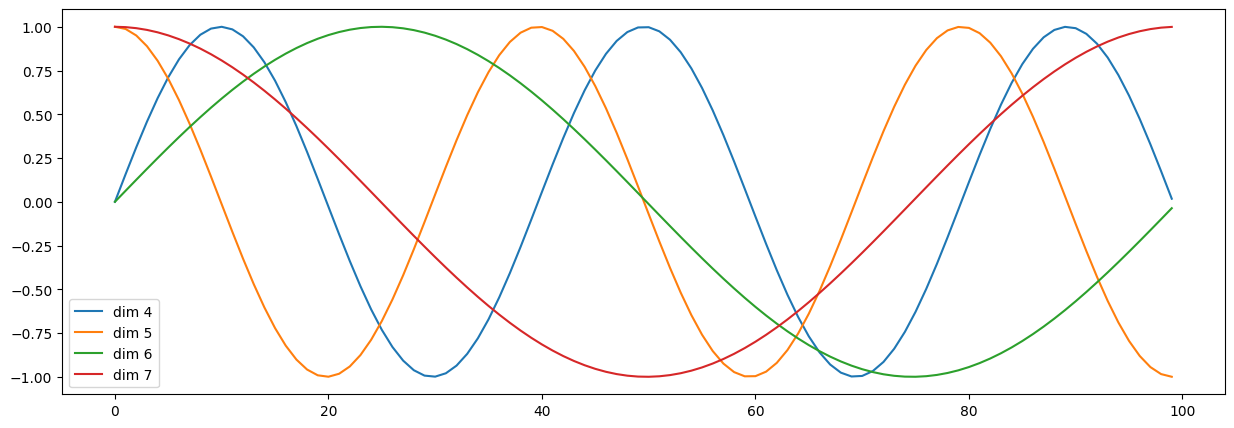

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])
plt.show()

В результате каждая позиция кодируется уникальным представлением. При этом представление позволяет легко находить слова на заданном расстоянии от исходного (у них будет одинаково значение сигнала по какой-то оси).

Это помогает трансформеру достаточно уникальным образом определять каждую позицию и понимать относительное расстояние между разными токенами.

**Почему не используется одно число, например, значение индекса?**

Для длинных последовательностей индексы могут сильно увеличиваться по величине. Если вы нормализуете значение индекса так, чтобы оно лежало между $0$ и $1$, это может создать проблемы для последовательностей переменной длины, поскольку они будут нормализованы по-разному.

Поэтому используется кодирование позиции в виде вектора, который прибавляется к эмбеддингу токена. Эти позиционные эмбеддинги можно как зафиксировать заранее (так делается в оригинальном трансформере, см. пример на картинке), так и обучать, как в случае GPT.

## Подготовка данных

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/preprocessing.png" width="600"></center>

Всё, что нам требуется для отправки данных в языковую модель, — почистить данные от очевидного мусора (это могут быть номера страниц, неверно распознанные символы), убрать картинки и таблицы.

При использовании трансформеров более не нужно использовать лемматизацию/стемминг. Вместо этого применяется **BPE** (Byte Pair Encodding), для нас же это выглядит как вызов токенизатора и подача в него сырого текста.

**Длинные тексты**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/transformer_xl.png" width="900"></center>

<center><em>Source: <a href="https://paperswithcode.com/method/transformer-xl">Transformer-XL</a></em></center>

Размер входа токенизатора ограничен, и чтобы подать очень длинный текст, потребуются некоторые ухищрения.

Классическим примером решения можно считать подход, реализованный в [Transformer-XL 🎓[arxiv]](https://arxiv.org/abs/1901.02860). Две основные идеи: рекуррентная обработка сегментов и относительное позиционное кодирование.

Длинный текст разбивается на сегменты, обработка производится по одному сегменту за раз. При этом выходы предыдущего сегмента кэшируются на всех слоях. При подсчёте self-attention в текущем сегменте ключи и значения считаются на основании выходов как для текущего сегмента, так и для предыдущего (они просто конкатенируются). Градиенты идут только в рамках текущего сегмента.

Такая схема не может работать с абсолютными позициями. Вместо добавления к входным эмбеддингам позиционных векторов информация о позиции добавляется напрямую в self-attention, для этого в модели репараметризуется формула подсчёта весов внимания. Абсолютные векторы заменяются на фиксированную матрицу на основе значений синусов от расстояний между позициями токенов и пару обучаемых векторов, общих для всех позиций.

[[blog] ✏️ Обзор зоопарка трансформеров](https://habr.com/ru/companies/just_ai/articles/733110/). Модели с приставкой XL будут вам полезны.

##HuggingFace

Hugging Face — это платформа и сообщество для разработки и обмена моделями машинного обучения в области обработки естественного языка (и не только). Здесь можно найти готовые модели, узнать об их параметрах и применении, а также делиться своими разработками и идеями с другими специалистами.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/huggingface.png" width="700"></center>

Можно выделить 4 основные составляющие
*   Токенизаторы
*   Модели
*   Датасеты
*   Обучение

**Tokenizers**

Библиотека служит для предобработки и постобработки данных:

* Токенизация (разделение строк на токены подслов)
* Кодирование/декодирование (токенизация и преобразование в целые числа)
* Добавление новых токенов в словарь.
* Управление специальными токенами (маской, началом предложения и т.д.)

🔥 Базово: используйте токенизатор и модель с одинаковыми именами.

In [ ]:
from IPython.display import clear_output

!pip install -q -U transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q sentencepiece sentence_transformers
!pip install -q -U datasets huggingface-hub
!pip install evaluate
clear_output()

In [ ]:
import torch
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

transformers.logging.set_verbosity_error()

# Loading and initialization of model and tokenizer
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
clear_output()

In [ ]:
text = "Нейронные сети - это очень просто и увлекательно"
tokens = tokenizer.encode(text, add_special_tokens=False)

decoded_tokens = [tokenizer.decode([token]) for token in tokens]

print("Original text:", text)
print("Tokens: ", tokens)
print("Decoded tokens: ", decoded_tokens)

Original text: Нейронные сети - это очень просто и увлекательно
Tokens:  [682, 355, 1368, 448, 5324, 376, 481, 939, 1139, 289, 13904, 1245]
Decoded tokens:  ['Н', 'ей', 'рон', 'ные', ' сети', ' -', ' это', ' очень', ' просто', ' и', ' увлека', 'тельно']



**Models**

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/hf_model.png" width="600"></center>

В базе Hugging Face находятся сотни моделей, рассортированных по типам задач, поддерживаемым языкам и пр.

🔥 Базово: выбираете модель во вкладке [Models 🛠️[doc]](https://huggingface.co/models), используете пример базового применения и класс `AutoModel`.

Вначале вы инициализируете модель. Затем загружаете в неё предобученные веса через функцию `from_pretrained`.

Также можно загрузить модель из локальной директории. Для этого нужно описать модель и сконфигурировать её. Важно отметить, что у одной и той же модели может быть несколько подклассов с говорящими названиями (например, `BertForSequenceClassification` и `BertForQuestionAnswering`).

In [ ]:
from transformers import AutoModel
from warnings import simplefilter

simplefilter("ignore", FutureWarning)

gpt_model = AutoModel.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")
print(type(gpt_model))

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

<class 'transformers.models.gpt2.modeling_gpt2.GPT2Model'>


In [ ]:
print(gpt_model)

GPT2Model(
  (wte): Embedding(50257, 1536)
  (wpe): Embedding(2048, 1536)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-23): 24 x GPT2Block(
      (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
)


In [ ]:
from transformers import GPT2Config

gpt_config = GPT2Config.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")
print(type(gpt_config))

print(gpt_config)

<class 'transformers.models.gpt2.configuration_gpt2.GPT2Config'>
GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 2048,
  "n_embd": 1536,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 2048,
  "pad_token_id": 0,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.40.2",
  "use_cache": true,
  "vocab_size": 50257
}



Все эти параметры можно менять и настраивать под себя. Для примера соберём модель на основе GPT, но поменьше.

In [ ]:
gpt_config = GPT2Config.from_pretrained(
    "sberbank-ai/rugpt3large_based_on_gpt2", num_hidden_layers=5
)
gpt_model = AutoModel.from_config(gpt_config)
print(gpt_model)

GPT2Model(
  (wte): Embedding(50257, 1536)
  (wpe): Embedding(2048, 1536)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-4): 5 x GPT2Block(
      (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
)



**Datasets**

Библиотека `datasets` содержит как наборы данных, так и функции для приведения ваших собственных данных к формату датасета для подачи в модель.

Посмотрим на примере датасета General Language Understanding Evaluation benchmark (GLUE).

In [ ]:
from datasets import load_dataset

raw_dataset = load_dataset("glue", "mrpc")
clear_output()

raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

Посмотрим, как в целом устроены датасеты:

In [ ]:
raw_dataset["train"][:4]

{'sentence1': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
  "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
  'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
  'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .'],
 'sentence2': ['Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
  "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .",
  "On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .",
  'Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .'],
 'label': [1, 0, 1, 0],
 'idx': [0, 1, 2, 3]}

Какие у данного датасета признаки:

In [ ]:
raw_dataset["train"].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

Для подачи данных в модель их нужно токенизировать:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Функция `tokeinze_func` обеспечивает токенизацию обоих предложений в датасете, причём мы указываем, что будем заполнять паддингом до 128 токенов. Всё, что более 128 токенов, будет обрезано и выкинуто (`truncation = True`).

In [ ]:
def tokeinze_func(example):
    return tokenizer(
        example["sentence1"],
        example["sentence2"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

 Применим функцию `Dataset.map()`, чтобы применить токенизацию ко всему датасету.

In [ ]:
tokenized_datasets = raw_dataset.map(tokeinze_func, batched=True)
tokenized_datasets["train"].column_names

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

['sentence1',
 'sentence2',
 'label',
 'idx',
 'input_ids',
 'token_type_ids',
 'attention_mask']

In [ ]:
len(tokenized_datasets["train"]["input_ids"][0])

128

Переводим датасет в формат `torch` (до этого он состоял из объектов типа `list`).



In [ ]:
tokenized_datasets = tokenized_datasets.with_format("torch")

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/tokens_descr.png" width="1000"></center>

Заметьте, к уже имеющимся колонкам, добавились токены и их типы (принадлежность к первому или второму предложению), а также `attention_mask` (padding мы не учитываем в работе, там будут стоять нули).



In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True)

batch = next(iter(train_dataloader))
print(batch["input_ids"].shape)

torch.Size([16, 128])


Для того, чтобы делать padding динамически, группируя предложения по их длине, можно использовать класс `DataCollatorWithPadding`.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Заново токенизируем датасет, но уже без указания `max_length`.

Отметим пару моментов:

* Придётся удалить лишние колонки, т.к. далее класс `DataLoader` будет работать только с тензорами.
* При обучении ожидается, что метки находятся в колонке с именем `labels`.

In [ ]:
def tokeinze_func_dyn(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_dataset.map(tokeinze_func_dyn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(
    ["idx", "sentence1", "sentence2"]
)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.with_format("torch")

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Размеры данных в токенах без паддинга.

In [ ]:
samples = tokenized_datasets["train"][:8]
samples = {
    k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]
}
[len(x) for x in samples["input_ids"]]

[52, 59, 47, 69, 60, 50, 66, 32]

В батчи будут сгруппированы данные следуюшим образом. Так мы экономим изрядное количество памяти и ускоряем обучение и инференс.

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 69]),
 'token_type_ids': torch.Size([8, 69]),
 'attention_mask': torch.Size([8, 69])}

Проверим, как выглядят батчи данных. Обратите внимание на аргумент `collate_fn` в `DataLoader`.

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], batch_size=16, shuffle=True, collate_fn=data_collator
)

for step, batch in enumerate(train_dataloader):
    print(batch["input_ids"].shape)
    if step == 3:
        break

torch.Size([16, 74])
torch.Size([16, 75])
torch.Size([16, 68])
torch.Size([16, 69])



**Trainer**

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/trainer_hf.png" width="700"></center>

Hugging Face обладает собственной обёрткой для обучения, идеологически схожей с `Lightning`, реализованной в классе **Trainer**.

В `Trainer` подаются аргументы для обучения, которые записываются в объект класса `TrainingArguments`, данные для обучения, валидирования и теста, описывается, как именно будут считаться метрики, а также `DataCollator`, который обеспечивает внутри `Trainer`'а обработку батчей.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", num_labels=2
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Модель в результате работы создаёт тензор из двух частей:
* Логиты модели
* Истинные метки (если есть)

Для того, чтобы определить класс, необходимо взять `argmax` от строки вывода.

In [ ]:
import evaluate
import numpy as np


def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    "test-trainer",
    evaluation_strategy="epoch",
    num_train_epochs=1,
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

{'eval_loss': 0.42301395535469055, 'eval_accuracy': 0.821078431372549, 'eval_f1': 0.8764805414551609, 'eval_runtime': 4.1143, 'eval_samples_per_second': 99.167, 'eval_steps_per_second': 12.396, 'epoch': 1.0}
{'train_runtime': 69.634, 'train_samples_per_second': 52.675, 'train_steps_per_second': 6.592, 'train_loss': 0.5658666407101035, 'epoch': 1.0}


TrainOutput(global_step=459, training_loss=0.5658666407101035, metrics={'train_runtime': 69.634, 'train_samples_per_second': 52.675, 'train_steps_per_second': 6.592, 'train_loss': 0.5658666407101035, 'epoch': 1.0})

Разберемся, как извлекать предсказания модели и оценивать качество.

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)
preds = np.argmax(predictions.predictions, axis=-1)

(1725, 2) (1725,)


In [ ]:
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.792463768115942, 'f1': 0.8520661157024794}

###Pipeline

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/full_nlp_pipeline.png" width="900"></center>

<center><em>Source: <a href="https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt">Hugging Face NLP course</a></em></center>

Наиболее простой способ работать с Hugging Face — использовать обёртку *pipeline*, которая включает в себя токенизацию, обработку токенов моделью и постобработку результата работы модели — перевод в человекочитаемое представление.

Вариантов базовых pipeline'ов множество, вот часть из них:
* feature-extraction (get the vector representation of a text)
* fill-mask
* ner (named entity recognition)
* question-answering
* summarization
* text-generation
* translation
* zero-shot-classification

Рассмотрим несколько наиболее распространённых задач.

**Sentiment Analysis**

С задачей оценки эмоциального окраса предложений мы познакомились в конце прошлой лекции.

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier("MSU AI is an amaizing course")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9802752137184143}]

**Zero-shot classification**

Zero Short Learning — это сценарий машинного обучения, в котором модель  обучается распознавать, классифицировать объекты без предварительного обучения на каких-либо примерах из этих категорий.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/zero_shot_learning.jpg" width="700"></center>

<center><em>Source: <a href="https://saturncloud.io/blog/breaking-the-data-barrier-how-zero-shot-one-shot-and-few-shot-learning-are-transforming-machine-learning/">Zero-Shot Learning</a></em></center>

In [ ]:
classifier = pipeline("zero-shot-classification")
classifier(
    "This is a chapter about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'sequence': 'This is a chapter about the Transformers library',
 'labels': ['business', 'education', 'politics'],
 'scores': [0.40918397903442383, 0.40756192803382874, 0.18325406312942505]}

***Генерация текста*** выглядит аналогично. Для выбора конкретной модели используется параметр `model`.

In [ ]:
generator = pipeline("text-generation", model="distilgpt2")
generator(
    "In this course, we will teach you how to", max_length=30, num_return_sequences=2
)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[{'generated_text': 'In this course, we will teach you how to use the tools and tools of a simple beginner’ that are currently in the development of a game'},
 {'generated_text': 'In this course, we will teach you how to work through the various issues involved with the "trends of life." We will teach you how'}]

Следующий pipeline служит для заполнения пропусков `<mask>` в тексте и называется ***fill-mask***.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/fill_mask.png" width="500"></center>

<center><em>Source: <a href="https://towardsdatascience.com/how-to-train-bert-for-masked-language-modeling-tasks-3ccce07c6fdc">How to Train BERT</a></em></center>

In [ ]:
unmasker = pipeline("fill-mask")
unmasker(
    "This course will teach you all about <mask> models and <mask> learning.", top_k=2
)

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[[{'score': 0.12782499194145203,
   'token': 30412,
   'token_str': ' mathematical',
   'sequence': '<s>This course will teach you all about mathematical models and<mask> learning.</s>'},
  {'score': 0.06281624734401703,
   'token': 774,
   'token_str': ' role',
   'sequence': '<s>This course will teach you all about role models and<mask> learning.</s>'}],
 [{'score': 0.21669012308120728,
   'token': 37700,
   'token_str': ' reinforcement',
   'sequence': '<s>This course will teach you all about<mask> models and reinforcement learning.</s>'},
  {'score': 0.148617222905159,
   'token': 3563,
   'token_str': ' machine',
   'sequence': '<s>This course will teach you all about<mask> models and machine learning.</s>'}]]

Важной задачей является разметка текстов, в частности, выделение именованных сущностей (**Named Entity Recognition**, ***NER***):

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/ner.png" width="800"></center>

In [ ]:
# ner = pipeline("ner", grouped_entities=True)
ner = pipeline("ner", aggregation_strategy="simple")
ner("My name is Alexander and I work at MSU.AI in Moscow.")

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

[{'entity_group': 'PER',
  'score': 0.9990042,
  'word': 'Alexander',
  'start': 11,
  'end': 20},
 {'entity_group': 'ORG',
  'score': 0.9947737,
  'word': 'MSU',
  'start': 35,
  'end': 38},
 {'entity_group': 'ORG',
  'score': 0.9969048,
  'word': 'AI',
  'start': 39,
  'end': 41},
 {'entity_group': 'LOC',
  'score': 0.99926883,
  'word': 'Moscow',
  'start': 45,
  'end': 51}]

Закончим с примерами задачей ***Question Answering, QA***.

В данном случае ответ не генерируется, а **извлекается** (extract) из контекста. Контекст не может быть пустым.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/qa_example.png" width="500"></center>

<center><em>Source: <a href="https://medium.datadriveninvestor.com/lets-build-an-ai-powered-question-answering-system-with-huggingface-transformers-2622d8de18e9">Question-answering system</a></em></center>

In [ ]:
question_answerer = pipeline("question-answering")
question_answerer(
    question="Where do I work?",
    context="My name is Alexander and I work at MSU.AI in Moscow.",
)

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.4669008255004883,
 'start': 35,
 'end': 51,
 'answer': 'MSU.AI in Moscow'}

Больше примеров тут: [Hugging Face NLP Course 🛠️[doc]](https://huggingface.co/learn/nlp-course/chapter1/1?fw=pt).

##BERT

### Постановка задачи

Модель решает две задачи.

1. MLM (masked language model) — предсказание маскированных токенов. Для этой задачи появляется специальный токен **[MASK]**.

2. NSP (Next Sentence Prediction) — предсказание, следует ли текущее предложение за предыдущим. Для этого появляются специальные токены [CLS] (для классификации) и [SEP] (для разделения предложений, которые подаются парой и следуют друг за другом).

Сеть училась на обеих задачах одновременно.

Для предсказания замаскированного токена используется дополнительный слой — классификатор. Аналогично, для решения задачи NSP выход токена [CLS] отправляется на полносвязную сеть.

**BERT — фактически взятый множество раз кодировщик.**

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/bert.png" width="600"></center>

Благодаря процедуре маскирования, BERT-подобные модели могут обучаться без учителя на огромных корпусах текстов, тем самым изучая стуктуру языка.

Далее предобученные BERT-подобные модели можно использовать так:

* использовать их выходы как признаки для других моделей (**downstream-задачи**);

* дообучать под наши задачи.

Посмотрим на инференс модели.

###RoBERTa

RoBERTa — это простая, но очень популярная альтернатива и преемник BERT. Она улучшает BERT за счет тщательной и разумной оптимизации обучающих гиперпараметров для BERT. Несколько простых изменений в совокупности повышают производительность RoBERTa и позволяют ей превзойти BERT практически во всех задачах.

* Увеличение датасета в 10 раз
* Увеличение батча от 256 до 8000 и больший словарь — от 30k до 50k
* Более длинные обучающие последовательности, но RoBERTa по-прежнему имеет ограничение на максимальное количество токенов — 512, как и у BERT
* Динамическое маскирование позволяет маскирующей схеме меняться при каждой подаче последовательности на модель. Отличие от BERT в том, что везде используется одна и та же маскирующая схема.


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/bert.png" width="700"></center>

<center><em>Source: <a href="https://naviglinlp.blogspot.com/2021/05/lecture-22-215-hours-bert-glue-and.html">BERT. RoBERTa. XLM-R.</a></em></center>

### Примеры применения

Вот так можно добыть в цикле эмбеддинги. Важно, что мы их переводим с GPU на CPU, тем самым существенно экономя память.

In [ ]:
import torch
from transformers import logging
from transformers import AutoTokenizer, AutoModel

logging.set_verbosity_error()

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
clear_output()


def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [ ]:
print("BERT output shape:", embed_bert_cls("Привет мир", model, tokenizer).shape)

BERT output shape: (312,)


У такого подхода есть минус. Нам необходимо разбираться с тем, как выглядит выход модели. Обычно это словарь, по одному из ключей которого находится нужный нам вектор.

Можем попробовать иную форму запуска.

Теперь подадим 3 предложения и убедимся, что их векторы-представления совпадают по размеру.

In [ ]:
from sentence_transformers import SentenceTransformer


model = SentenceTransformer("cointegrated/rubert-tiny2")
sentences = ["привет мир", "hello world", "предложение подлиннее для проверки"]
embeddings = model.encode(sentences)
clear_output()

print("BERT output shape:", embeddings.shape)

BERT output shape: (3, 312)


Самый простой способ использовать готовые модели — импортировать [pipeline 🛠️[doc]](https://huggingface.co/docs/transformers/main_classes/pipelines).

Попробуем оценить сегодняшнюю погоду.

In [ ]:
from transformers import pipeline

classifier = pipeline(
    task="sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment"
)
clear_output()
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [ ]:
classifier("Отличное морозное утро!")

[{'label': 'POSITIVE', 'score': 0.9534334540367126}]

In [ ]:
classifier("Отличное морозное утро, холод собачий!")

[{'label': 'NEGATIVE', 'score': 0.7517328858375549}]

А теперь давайте возьмём задачку посложнее и классифицируем услышанный звук.

Режим работы модели — "zero-shot learning", т.е. модель не видела во время обучения подобные данные.

В качестве примера звука возьмём сэмпл из датасета [ESC: Dataset for Environmental Sound Classification 🛠️[doc]](https://huggingface.co/datasets/ashraq/esc50).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ashraq/esc50", split="train", streaming=True)
audio = next(iter(dataset))
clear_output()

In [ ]:
audio

{'filename': '1-100032-A-0.wav',
 'fold': 1,
 'target': 0,
 'category': 'dog',
 'esc10': True,
 'src_file': 100032,
 'take': 'A',
 'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 44100}}

In [ ]:
from IPython.display import Audio, display

display(Audio(audio["audio"]["array"], rate=16000, autoplay=True))

Предложим скачанной модели варианты ответов: собачий лай или крик попугая.

In [ ]:
classifier = pipeline(
    task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
)
clear_output()
classifier(
    audio["audio"]["array"], candidate_labels=["Sound of a dog", "Parrot scream"]
)

[{'score': 0.7676398754119873, 'label': 'Sound of a dog'},
 {'score': 0.23236016929149628, 'label': 'Parrot scream'}]

### Примеры с обучением

Базовый вариант работать с векторами из моделей BERT — работать с ними как с вектор-представлениями наших данных.

И подавать эти вектора на уже известные нам модели.

Загрузим [новостные сводки BBC 🛠️[doc]](https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification) и научимся их классифицировать.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/bbc.zip
!unzip -q bbc.zip

Соберём данные в таблицу `pandas`.

In [ ]:
import os

directory = []
file = []
title = []
text = []
label = []
datapath = "./bbc/"
for dirname, _, filenames in os.walk(datapath):
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove("README.TXT")
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split("/")[-1])
        fullpathfile = os.path.join(dirname, filename)
        with open(fullpathfile, "r", encoding="utf8", errors="ignore") as infile:
            intext = ""
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace("\n", ""))
                    firstline = False
                else:
                    intext = intext + " " + line.replace("\n", "")
            text.append(intext)

In [ ]:
import pandas as pd

fulldf = pd.DataFrame(
    list(zip(directory, file, title, text, label)),
    columns=["directory", "file", "title", "text", "category"],
)

df = fulldf.filter(["text", "category"], axis=1)
df.head()

,text,category
0,Ronnie Corbett has joined fellow comedy star...,entertainment
1,Senegalese musician Youssou N'Dour has been ...,entertainment
2,Japan's box office received a 3.8% boost las...,entertainment
3,A novel set in 19th century Paraguay has won...,entertainment
4,"Record producer Terry Melcher, who was behin...",entertainment


Проверим, какие у нас метки.

In [ ]:
import numpy as np

for label in np.unique(df["category"]):
    print(label)

business
entertainment
politics
sport
tech


Переведём эти текстовые классы в числовые метки.

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df["label"] = LE.fit_transform(df["category"])
df.head()

,text,category,label
0,Ronnie Corbett has joined fellow comedy star...,entertainment,1
1,Senegalese musician Youssou N'Dour has been ...,entertainment,1
2,Japan's box office received a 3.8% boost las...,entertainment,1
3,A novel set in 19th century Paraguay has won...,entertainment,1
4,"Record producer Terry Melcher, who was behin...",entertainment,1


Отметьте, что мы используем параметр `model_max_length`. Это необходимо как потому, что на длинных текстах получаются вектора большей длины, так и потому, что очень хочется не выйти за границы доступной памяти в Google Colab.

Используем небольшую модель.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", model_max_length=312)
model = AutoModel.from_pretrained("prajjwal1/bert-tiny").to(device)
clear_output()

Посмотрим на количество текстов. Относительно много.

In [ ]:
print(len(df))

2225


Оставим случайные 50% датасета для экономии ресурсов.

In [ ]:
df = df.sample(frac=0.5)

Разделим на обучение и валидацию.

In [ ]:
df_train = df.sample(frac=0.8)
df_val = df.drop(df_train.index)

In [ ]:
tokenized_train = tokenizer(
    df_train["text"].values.tolist(), padding=True, truncation=True, return_tensors="pt"
)
tokenized_val = tokenizer(
    df_val["text"].values.tolist(), padding=True, truncation=True, return_tensors="pt"
)

print(tokenized_train.keys())

# move on device (GPU)
tokenized_train = {k: torch.tensor(v).to(device) for k, v in tokenized_train.items()}
tokenized_val = {k: torch.tensor(v).to(device) for k, v in tokenized_val.items()}
clear_output()

In [ ]:
with torch.no_grad():
    hidden_train = model(
        **tokenized_train
    )  # dim : [batch_size(nr_sentences), tokens, emb_dim]
    hidden_val = model(**tokenized_val)

# get only the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:, 0, :]
cls_val = hidden_val.last_hidden_state[:, 0, :]

In [ ]:
x_train = cls_train.to("cpu")
y_train = df_train["label"]

x_val = cls_val.to("cpu")
y_val = df_val["label"]

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

torch.Size([890, 128]) (890,) torch.Size([222, 128]) (222,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_val_pred = rf.predict(x_val)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val_pred, y_val.values))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        52
           1       0.92      0.97      0.94        35
           2       0.83      0.81      0.82        43
           3       1.00      1.00      1.00        48
           4       0.96      0.98      0.97        44

    accuracy                           0.92       222
   macro avg       0.92      0.92      0.92       222
weighted avg       0.92      0.92      0.92       222



Сравним с Dummy-классификатором. Результат говорит о том, что наш хороший результат получился не просто так.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="uniform")
dummy.fit(x_train, y_train)
y_val_pred = dummy.predict(x_val)

In [ ]:
print(classification_report(y_val_pred, y_val.values))

              precision    recall  f1-score   support

           0       0.16      0.21      0.18        38
           1       0.22      0.21      0.21        38
           2       0.36      0.28      0.31        54
           3       0.12      0.16      0.14        37
           4       0.29      0.24      0.26        55

    accuracy                           0.23       222
   macro avg       0.23      0.22      0.22       222
weighted avg       0.24      0.23      0.23       222



**А теперь дообучим саму модель BERT**

In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb")
clear_output()

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("sberbank-ai/ruBert-base")
model = BertForSequenceClassification.from_pretrained("sberbank-ai/ruBert-base").to(
    device
)
clear_output()

Обратим внимание на то, как выглядят датасет и его содержимое.

In [ ]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

Предобработка данных. Будем использовать токенизатор (и модель) `distilbert-base-uncased` для работы с английским текстом.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
print(tokenized_imdb["test"]["label"])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Объект `DataCollator` потребуется нам для создания батчей из данных.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
!pip install -q evaluate

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Обратим внимание на `tokenized_imdb`. В них содержатся не только токенизированные данные, но и столбцы `labels`. Если мы захотим использовать свои собственные названия, то их нужно указать в параметре `label_names` в `TrainingArguments`.

Для запуска процесса обучения раскомментируйте последнюю строку.

In [ ]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # about 25 minutes for 1 epoch
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

clear_output()
# trainer.train()

## Декодировщик

<div align="center">
    <table >
     <tr>
       <td>
       
Авторегрессионный синтез последовательности:

$\large y_0 = \langle {BOS} \rangle$ — эмбеддинг символа начала.

Для всех $t = 1, 2, \dots$ выполняется следующая последовательность вычислений:

1. Маскирование "данных из будущего":

$\qquad \large h_t = y_{t-1} + p_t;$

$\qquad \large H_t = (h_1, \dots, h_t).$

2. Многомерное самовнимание:

$\qquad \large h'_t = LN \circ MH_j \circ Attn(\color{red}{W^j_q}h_t, \color{red}{W^j_k}H_t, \color{red}{W^j_v}H_t).$

3. Многомерное внимание на кодировку $Z$:

$\qquad \large h''_t = LN \circ MH_j \circ Attn(\color{red}{W^j_q}h'_t, \color{red}{W^j_k}Z, \color{red}{W^j_v}Z).$

4. Двухслойная полносвязная сеть:

$\qquad \large y_t = LN \circ FFN(h''_t).$

5. Линейный предсказывающий слой:

$\qquad \large p(\tilde w | t) \text{SoftMax}_{\tilde w}(\color{red}{W_y}y_t + b_y).$

Генерация $\tilde w_t = argmax(p(\tilde w | t))$ продолжается пока $\tilde w_t \neq \langle {EOS} \rangle$.

       
</td>
<td>
<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/transformer_decoder.png" width="350">

<em>Архитектура трансформера-декодировщика</em>

<em>Source: <a href="http://www.machinelearning.ru/wiki/images/1/19/Voron-ML-Attention-slides.pdf"> К.В. Воронцов, Машинное обучение:

Обработка последовательностей и модели внимания</a></em>
        </td>
     </tr>
    </table>
    </div>

### Masked Self-Attention Layer

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/masked_self_attention.png" width="600"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/490842/">GPT-2 в картинках</a></em></center>

Ключевой идеей декодировщика является **маскированное самовнимание**.

Решаемая проблема заключается в том, что мы не должны видеть часть слов в предложении. Например,
мы хотим сгенерировать фразу на основе только первого слова.

Если мы подадим в нейронную сеть во время обучения сразу все предложение, которое хотим генерировать, то у нас в первых словах будет "протекать" информация о предыдущих.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/gpt_decoder.png" width="700"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/490842/">GPT-2 в картинках</a></em></center>

Благодаря этому трюку у нас получается обучать transfomer по-прежнему как простую single-pass нейросеть, а не "скатываться" в RNN, где у нас возникнут проблемы с градиентами и временем работы.

## GPT

### Постановка задачи

Есть широкий класс задач по пониманию естественного языка (распознавание текста, ответы на вопросы и пр.). Гипотеза состояла в том, чтобы добиться успеха путём генеративной предварительной подготовки языковой модели на разнообразном корпусе неразмеченного текста с последующей дискриминационной тонкой настройкой для каждой конкретной задачи.

Для решения задачи обучения без учителя вводился Masked Self-Attention, о котором говорилось выше.

**GPT — фактически взятый множество раз декодировщик.**

### Архитектура

При генерации продолжения текста с помощью GPT происходит следующее:

1. Входной текст токенизируется в последовательность чисел (токенов).
2. Список токенов проходит через Embedding layer (линейный слой) и преобразуется в список эмбеддингов.
3. К каждому эмбеддингу прибавляется **positional embedding**.
4. Список эмбеддингов проходит через несколько одинаковых блоков (Transformer Decoder Block).
5. После того, как список эмбеддингов пройдёт через последний блок, эмбеддинг, соответствующий последнему токену, матрично умножается на всё тот же входной, но уже транспонированный Embedding Layer, и после применения SoftMax получается распределение вероятностей следующего токена.
6. Из этого распределения выбирается следующий токен (например, с помощью argmax)
7. Полученный токен добавляется к входному списку токенов, шаги 1–6 повторяются

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/gpt3.gif" width="800"></center>

<center><em>Source: <a href="https://jalammar.github.io/how-gpt3-works-visualizations-animations/">How GPT3 Works — Visualizations and Animations</a></em></center>

Далее часть текста основана на статье [GPT для чайников: от токенизации до файнтюнинга ✏️[blog]](https://habr.com/ru/articles/599673/).


### Пример применения

Для работы с GPT будем использовать предобученную модель. Лучший выбор для работы с трансформерами — библиотеки от **Hugging Face**: `transformers`, `tokenizers`, `datasets`.

Hugging Face занимается стандартизацией применения трансформеров, а также хранит наборы весов и датасеты для различных NLP-задач. Воспользуемся русскоязычной моделью ruGPT3 и дообучим её.



Установим библиотеку Transformers:

In [ ]:
!pip install -q -U transformers accelerate git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Выберем необходимую модель. API для различных моделей одинаковый, для подмены модели достаточно изменить название модели `model_name`.

In [ ]:
import torch
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from IPython.display import clear_output

transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading and initialization of model and tokenizer
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

clear_output()

Например, если мы хотим при помощи языковой модели ответить на вопрос: **«Сколько будет 2+2?»**, то можем подать на вход модели следующий текст:\
`«Вопрос: Сколько будет 2+2? Ответ: … »`\
и естественным продолжением такого текста будет ответ на вопрос, поэтому модель допишет `«4»`

In [ ]:
text = "Вопрос: 'Сколько будет 2+2?'\nОтвет:"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
out = model.generate(input_ids, do_sample=False, max_length=20, pad_token_id=20)

generated_text = list(map(tokenizer.decode, out))[0]

print(generated_text)

Вопрос: 'Сколько будет 2+2?'
Ответ: '2+2=4'


Похожим способом можно кратко пересказывать тексты, если в конце дописывать `«TL:DR»`, т.к. модель во время обучения запомнила, что после этих символов идёт краткое содержание. Подбор модификаций текста называется **«Prompt Engineering»**. Такая простая идея позволяет решать практически неограниченное количество задач. Именно поэтому многие считают GPT-3 подобием сильного искусственного интеллекта.

## Методы Генерации текста

Языковая модель генерирует распределение вероятностей следующего токена. Однако способы генерации текста могут отличаться. Далее разберём, какие варианты бывают.

Для наглядности применим основные методы для продолжения следующего текста:  \
`'Определение: "Нейронная сеть" — это'`

In [ ]:
text = 'Определение: "Нейронная сеть" - это'
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)

### Greedy Search

Очевидный вариант — ArgMax-генерация (жадный поиск). Выбирается максимально вероятный токен.

При таком способе мы не получим разнообразного текста на один и тот же запрос, и, что ещё хуже, генерация может застревать в локальных минимумах и выдавать повторяющиеся фрагменты, например `the the the the ...`.

In [ ]:
# ArgMax is defaulf behaviour
out = model.generate(input_ids, do_sample=False, max_length=30, pad_token_id=30)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это компьютерная программа, которая позволяет создавать и анализировать нейронные сети. Нейронные сети


### Beam Search
Несколько более сложный и качественный способ сэмплирования — **beam search**. Каждый раз мы выбираем не один самый вероятный токен, а сразу несколько (`beam-size`), и дальше продолжаем поиск для каждого из выбранных токенов.

Таким образом создаётся **граф** со сгенерированными **вариантами предложений**. Далее выбирается предложение с наибольшей **perplexity** (уверенностью модели в реалистичности текста).

Обычно это приводит к высокой связности (когерентности) текста, но при этом к сухости и скучности текста. Также это не решает полностью проблему с повторениями кусочков текста.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/beam_search.png" width="500"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/599673/">GPT для чайников: от токенизации до файнтюнинга</a></em></center>



In [ ]:
# Generation with beam-search
out = model.generate(
    input_ids, do_sample=False, num_beams=5, max_length=30, pad_token_id=30
)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это компьютерная сеть, состоящая из компьютеров, соединенных друг с другом. Нейронная


### Сэмплирование с Температурой

Чтобы добавить тексту непредсказуемости и человечности, можно использовать вероятностное сэмплирование с температурой. Будет использоваться не самый вероятный токен, а случайный, с учётом распределения вероятностей.

Параметр температуры позволяет контролировать степень случайности. При нулевой температуре метод совпадает с жадным сэмплированием, при  большой температуре токены будут выбираться полностью случайно. Обычно хорошо работает температура в диапазоне `0.8–2.0`.

Формула модификации распределения вероятностей очень похожа на формулу распределения Больцмана: чем выше температура системы, тем больше "размазывается" распределение вероятностей её возможных состояний, отсюда слово "температура".

$$\large p=\text{softmax}(\log(p)/t)$$

Стоит отметить, что случайная природа генерации будет иногда приводить к полностью некорректным результатам.

In [ ]:
out = model.generate(
    input_ids, do_sample=True, temperature=1.3, max_length=30, pad_token_id=30
)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это процесс функционирования данных процессов через компьютерные сети для создания сети. Сеть, организованная по такому


### Сэмплирование с Ограничением Маловероятных Токенов (Nucleus sampling)

Можно ввести запрет на сэмплирование наименее вероятных токенов:

* `top-k` зануляет все вероятности, кроме $k$ наибольших;

* `top-p` оставляет минимальный набор токенов, причём сумма их вероятностей будет не больше $p$.

`top-p` ограничение называют **Nucleus Sampling**.

In [ ]:
out = model.generate(
    input_ids,
    do_sample=True,
    temperature=1.3,
    top_k=20,
    top_p=0.8,
    max_length=30,
    pad_token_id=30,
)

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Определение: "Нейронная сеть" - это математическая модель, описывающая взаимодействие нейронов в процессе их взаимодействия. Она состоит из множества


## Файнтюнинг

Воспользуемся моделью меньшего размера, чтобы она поместилась на GPU.

In [ ]:
import torch
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from IPython.display import clear_output

transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

clear_output()

### Процесс обучения

Обучающий текст нарезается на случайные блоки, которые составляются в последовательности из 1024 (2048 у GPT-3) токенов, разделяясь специальным `<|endoftext|>` символом. Во время обучения модель учится предсказывать (классифицировать) каждый токен в последовательности один за другим при помощи Cross-Entropy Loss.

Так как входная последовательность всегда заполнена до конца, padding не используется. Но во время инференса длина входного текста может быть произвольной, поэтому надо явно указывать, чем дополнять оставшиеся позиции. По дефолту использутеся тот же `<|endoftext|>`.

В отдельных версиях GPT вышесказанное может модифицироваться. Например, в ruGPT3 гораздо больше специальных токенов: `<s\>`, `<s>`, `<pad>`, `<unk>`

**Обучающие данные**

Будем учить GPT генерировать стихи Маяковского. В качестве обучающих данных возьмём всего лишь один стих.

In [ ]:
text = """Дым табачный воздух выел.
Комната —
глава в крученыховском аде.
Вспомни —
за этим окном
впервые
руки твои, исступленный, гладил.
Сегодня сидишь вот,
сердце в железе.
День еще —
выгонишь,
может быть, изругав.
В мутной передней долго не влезет
сломанная дрожью рука в рукав.
Выбегу,
тело в улицу брошу я.
Дикий,
обезумлюсь,
отчаяньем иссеча́сь.
Не надо этого,
дорогая,
хорошая,
дай простимся сейчас.
Все равно
любовь моя —
тяжкая гиря ведь —
висит на тебе,
куда ни бежала б.
Дай в последнем крике выреветь
горечь обиженных жалоб.
Если быка трудом уморят —
он уйдет,
разляжется в холодных водах.
Кроме любви твоей,
мне
нету моря,
а у любви твоей и плачем не вымолишь отдых.
Захочет покоя уставший слон —
царственный ляжет в опожаренном песке.
Кроме любви твоей,
мне
нету солнца,
а я и не знаю, где ты и с кем.
Если б так поэта измучила,
он
любимую на деньги б и славу выменял,
а мне
ни один не радостен звон,
кроме звона твоего любимого имени.
И в пролет не брошусь,
и не выпью яда,
и курок не смогу над виском нажать.
Надо мною,
кроме твоего взгляда,
не властно лезвие ни одного ножа.
Завтра забудешь,
что тебя короновал,
что душу цветущую любовью выжег,
и су́етных дней взметенный карнавал
растреплет страницы моих книжек…
Слов моих сухие листья ли
заставят остановиться,
жадно дыша?
Дай хоть
последней нежностью выстелить
твой уходящий шаг.."""

В библиотеке transformers есть готовые инструменты для подготовки датасета и даталодера. На вход нужен всего лишь один `.txt` файл с обучающим текстом.

In [ ]:
# Save text train data as .txt file
train_path = "train_dataset.txt"
with open(train_path, mode="w", encoding="utf-8") as f:
    f.write(text)

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Creating Dataset
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=64)

# Сreating DataLoader (crop the text into optimal length pieces)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

**Обучение**

Для файнтюнинга нам необходим объект класса Trainer, который сделает всю работу за нас. Далее нужно будет всего лишь запустить `trainer.train()`.

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuned",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=200,  # number of training epochs
    per_device_train_batch_size=32,  # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    warmup_steps=10,  # number of warmup steps for learning rate scheduler
    gradient_accumulation_steps=16,  # to make "virtual" batch size larger
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5),
        None,
    ),  # Optimizer and learnig rate scheduler
)

In [ ]:
trainer.train()

{'train_runtime': 39.0697, 'train_samples_per_second': 35.833, 'train_steps_per_second': 5.119, 'train_loss': 0.04006211280822754, 'epoch': 200.0}


TrainOutput(global_step=200, training_loss=0.04006211280822754, metrics={'train_runtime': 39.0697, 'train_samples_per_second': 35.833, 'train_steps_per_second': 5.119, 'train_loss': 0.04006211280822754, 'epoch': 200.0})

**Результат файнтюнинга**

Готово! Теперь давайте посмотрим, что же сочинит GPT в стиле Маяковского, если на вход подать такую строчку:

"Учим нейросеть за нейросетью!"

In [ ]:
# Probability sampling with limit example
text = "Как же сложно учить матанализ!\n"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True,
        num_beams=3,
        temperature=1.9,
        top_p=0.9,
        max_length=100,
        pad_token_id=512,
    )

generated_text = list(map(tokenizer.decode, out))[0]

print(generated_text)

Как же сложно учить матанализ!
выучить надо...
Чтобы учить, не надо ни ума, ни таланта,
ни любви, ни денег,
ни любви, ни славы.
Надо просто любить,
а учить - не надо.
Все,
что ни делается - к лучшему.
Завтра забудешь,
что тебя короновали,
а в один прекрасный момент и вовсе
отправят на пенсию.
Все,
что ни делается - к лучшему


# Большие языковые модели (LLM)

Обычно этот термин относится к моделям с более чем миллиардом параметров. Обученные на больших данных, такие модели можно считать неструктурированными базами данных, изучивших в определенной степени синтаксис и семантику языка.

## LLaMA

[[arxiv] 🎓 LLaMA: Open and Efficient Foundation Language Models](https://arxiv.org/pdf/2302.13971.pdf)

[[blog] ✏️ Подробное описание](https://cameronrwolfe.substack.com/p/llama-2-from-the-ground-up)

Продолжение развития декодеров. Концепция Large Language Model Meta AI заключается в обучении меньших моделей на бОльшем количестве данных.

LLaMA-13B превосходит GPT-3 по большинству тестов, несмотря на то, что она в 10 раз меньше.

* Pre-normalization [GPT3]. Нормализация входных данных каждого подслоя вместо нормализации выходных данных. RMSNorm.
* Активация SwiGLU [PaLM]. Пришла на место ReLU.
* Rotary Embeddings [GPTNeo]. Вместо абсолютных позиционных эмбеддингов вводятся новые.

**LLaMA2**

По сравнению с первой версией:

* +40% данных для обучения
* контекст 4096 токенов (х2 LLAMA)
* механизм внимания Grouped-query





<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/llama_2_attention.png" width="800"></center>

<center><em>Механизм Attention в LLaMA2</em></center>

<center><em>Source: <a href="https://arxiv.org/abs/2305.13245"> Ainslie, Joshua, et al. "GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints."</a></em></center>



**GQA** — модифицированная версия уже виденного нами Self-Attention, в которой общее количество голов внимания делится на группы, внутри которых Key и Value общие.

Существенное внимание уделено процедуре обучения и человеческой оценке ответов по широкому перечню критериев, от соответствия ответов предметной области до их токсичности, предвзятости и дискриминированию по тому или иному критерию.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/llama.png" width="400"></center>

<center><em>Метрики модели LLaMA</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2302.13971.pdf"> LLaMA: Open and Efficient Foundation Language Models</a></em></center>

**NLP и обучение с подкреплением (RLHF)**

Модели типа LLaMA-Chat оптимизированы для диалоговых взаимодействий. Такие модели обучаются либо с помощью подхода Supervised Fine-Tuning (**SFT**), или через  Reinforcement Learning from Human Feedback (**RLHF**), или их комбинаций.

Создаётся датасет, состоящий из промтов. На этапе SFT семплируются промты, и человек сообщает модели правильные ответы, тем самым настраивая её.

На этапе RLHF проиходит сэмплирование промта и нескольких ответов модели. Человек ранжирует ответы от лучшего к худшему, что далее используется в обучении.

Задача состоит в том, чтобы уточнять работу модели политики генерации ответов. Ранжирование ответов является функцией награды для обновления политики.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/rlhf.png" width="1000"></center>

<center><em>Обучение с помощью RLHF</em></center>

<center><em>Source: <a href="https://arxiv.org/abs/2307.09288"> Touvron, Hugo, et al. "Llama 2: Open Foundation and Fine-Tuned Chat Models."</a></em></center>

RLHF позволяет исправить то, что было заложено как во время предобучения, так и во время обучения методом SFT. Это могут быть ошибки или нежетальное поведение модели с точки зрения разработчиков.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/prediction_vs_reward_model.png" width="800"></center>

<center><em>Сравнение стуктуры модели для предсказания следующего токена и модели вознаграждения</em></center>

<center><em>Source: <a href="https://cameronrwolfe.substack.com/p/llama-2-from-the-ground-up#footnote-anchor-9-135824233"> CAMERON R. WOLFE, "LLaMA-2 from the Ground Up."</a></em></center>

Модель вознаграждения имеет ту же архитектуру и веса, что и остновная модель. Разница в том, что слой классификации (предсказание токена) заменён на слой регрессии.

Модель штрафует за разницу между предспочтительным человеческим ответом и имеющимся машинным. Кроме того, в это выражение добавляется смещение, которое характеризуется выбранной человеком оценкой качества ответа.

$$\large L_{\text{ranking}} = - \log (σ(r_{θ}(x, y_c))-σ(r_{θ}(x, y_r))-m(r))$$

Стоит учесть, что одновременно обучается множество моделей вознаграждения, которые отвечают различным характеристикам ответов модели: от безопасности до полезности ответа.

**Какие ещё есть БЯМ?**

Hugging Face [предоставляет поисковик 🛠️[doc]](https://huggingface.co/models), позволяющий выбрать БЯМ под задачу и язык, включая модели с открытым исходным кодом.

Расширенный поисковик, агрегирующий модели со всей сети, с возможностью выбора размера модели, наличия квантованя и прочего [находится тут 🛠️[doc]](https://llm.extractum.io/).

## LoRa

Допустим, у нас есть один линейный слой без функции активации.

Если на вход мы подадим $x$, на выходе получим $y = Wx$, где $W$ — матрица весов.

Мы хотим немного изменить принцип работы этого слоя, дообучив модель, скорректировав веса на $\Delta W$.

$$\large y' = W'x = (W + \Delta W )x = y + \Delta W x$$
Как мы видим, новый $y$ отличается от старого на $\Delta W x$, что можно интерпретировать как результат работы еще одного, отдельного, полносвязного слоя.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/low_rank.png" width="800"></center>

<center><em>Принцип работы Low Rank, $r$ — ранг матрицы $\Delta W$</em></center>

<center><em>Source: <a href="https://habr.com/ru/articles/747534/"> Кто же такая эта ваша LoRA</a></em></center>

Матрицу $W$ заморозим, а матрицу $\Delta W$ разложим в произведение двух векторов. **Lo**w **Ra**nk — матрицу маленького ранга можно представить как произведение двух меньшей размерности. Обучаемых параметров становится существенно меньше, однако исследования говорят о том, что большая часть весов в LLM "не работает". Подробнее:
* [[arxiv] 🎓 LoRA: Low-Rank Adaptation of Large Language models (Hu et al., 2021)](https://arxiv.org/pdf/2106.09685.pdf)
* [[arxiv] 🎓 Measuring the Intrinsic Dimension of Objective Landscapes (Li et al., 2018)](https://arxiv.org/abs/1804.08838))

Таким образом, учим только веса в матрицах $А$ и $В$.

Преимущества:
* можно учить на слабом железе,
* понижение требований к датасету,
* снижение размера, можно хранить базовую модель и несколько LoRa-модулей,
* возможность заменять модули налету.

**QLoRa**

Квантование модели приводит к снижению точности представления весов, но даёт существенный прирост в производительности модели.

* **float32** $\to$ **int8**

Основная идея данного метода, заключается в том, что, несмотря на то, что `float32` покрывает огромный диапазон значений, бОльшая часть весов в нейросетях лежит около 0. Таким образом мы выделяем больше "уровней" ближе к началу координат, и меньше — вдалеке.

При этом в LoRa модули используют float32 и учатся исправлять ошибки квантования.

А теперь посмотрим в коде, как это делается. Для этого перейдем в блокнот с дообучением модели.

[[colab] 🥨 Блокнот с дообучением LLAMA2 на свой датасет](https://colab.research.google.com/drive/1MsZIOzaeZuB1BraIgzSYSo3cmw4rqgy8)

[[blog] ✏️ Различные методы оптимизации нейросетей](https://habr.com/ru/companies/doubletapp/articles/722798/)

##DeepSpeed

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/deepspeed_zero.png" width="900"></center>

[[git] 🐾 Библиотека с открытым исходным кодом](https://github.com/microsoft/DeepSpeed) для оптимального обучения и инференса больших языковых моделей.

Позволят максимально утилизировать имеющиеся ресурсы видеокарт и при этом уменьшить количество кода. Бесшовно работает с Hugging Face.

#NLP метрики

<font color='red'>Выбирайте метрику под свою конкретную задачу!</font> Или даже конструируйте её самостоятельно.

Помните эту картинку с предыдущей лекции? Сегодня мы упомянем нейросетевые метрики.

**BLEURT, Prism** — нейросети, последние слои которых принимают на вход **эмбеддинги машинного и эталонного переводов**, а на выходе дают оценку качества перевода.

**COMET, UniTE** — нейросети, принимающие **эмбеддинги машинного и эталонного переводов**, **оригинал** переводимого текста.

**Безреференсные метрики** — модели, сравнивающие **напрямую машинный перевод и первоисточник** (reference-free metrics).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/nlp_metrics.png" width="1000"></center>

**Базовым ответом** на вопрос о том, какую же метрику использовать для нейросетевых задач, будет **BertScore**.

[[blog] ✏️ Перечень метрик и их объяснений](https://habr.com/ru/articles/745642/)

## BertScore

**BERTScore**

Одна из самых популярных метрик, [предложенная Zhang et al. 🎓[arxiv]](https://arxiv.org/pdf/1904.09675.pdf) в 2019 для оценки качества генерируемого текста. Основана на оценке близости контекстных эмбеддингов, полученных из предобученной нейросетевой модели BERT. Частично **решает проблему синонимов и опечаток** метрик BLEU и ROUGE.

Для расчета BERTScore близость двух предложений — сгенерированного моделью и эталонного — оценивается как сумма косинусных подобий между эмбеддингами слов, составляющих эти предложения.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/architecture_bertscore.png" width="1000"></center>

<center><em>Source: <a href="https://wiki.math.uwaterloo.ca/statwiki/index.php?title=BERTScore:_Evaluating_Text_Generation_with_BERT">The Illustrated GPT-2 (BERTScore: Evaluating Text Generation with BERT)</a></em></center>

На основе обоих токенов рассчитывается $R_\text{BERT}, P_\text{BERT}$ и $F_\text{BERT}$, авторы оригинальной статьи проводят аналогии с *Presicion*, *Recall* и F1:

$$\large R_{\text{BERT}} = \dfrac{1}{|x|}∑\limits_{x_i \in x}\max_{\hat x_j \in \hat x} x^T_i \hat x_j , \quad P_{\text{BERT}} = \dfrac{1}{|\hat x|}∑\limits_{\hat x_j \in \hat x}\max_{x_i \in x} x^T_i \hat x_j , \quad F_{\text{BERT}} = 2 \frac{P_{\text{BERT}} \cdot R_{\text{BERT}}}{P_{\text{BERT}} + R_{\text{BERT}}}$$

Опционально оценка взвешивается на $\text{IDF}$ — обратную частоту встречаемости слова в корпусе текстов.

Научимся измерять BertScore!

In [ ]:
!pip install -q bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00


Из [важных параметров 🛠️[doc]](https://huggingface.co/spaces/evaluate-metric/bertscore) стоит упомянуть выбор языка и тип модели. По умолчанию используется `roberta-large`, и, чтобы не загружать 1.4G Гб, мы выставляем более мелкую модель, менее чем в 300 Мб.

In [ ]:
from evaluate import load

bertscore = load("bertscore")
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general darth vader"]
results = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="en",
    nthreads=-1,
    batch_size=128,
    model_type="distilbert-base-uncased",
)

In [ ]:
results

{'precision': [0.9999999403953552, 0.6674250364303589],
 'recall': [0.9999999403953552, 0.6521936655044556],
 'f1': [0.9999999403953552, 0.6597214341163635],
 'hashcode': 'distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.40.2)'}

Отметим, что результат зависит от того, что мы принимаем за референс. Поэтому мы получаем пару чисел.

Кроме того, обратите внимание на то, что сравнение оценок из разных моделей BertScore будет не вполне корректным.

# Self Attention (ViT 2020)

[[arxiv] 🎓 Visual Transformers: Token-based Image Representation and Processing for Computer Vision (Wu et al., 2020)](https://arxiv.org/abs/2006.03677)

[[git] 🐾 Реализация](https://github.com/lucidrains/vit-pytorch)

[[blog] ✏️ Разбор ViT](https://viso.ai/deep-learning/vision-transformer-vit/)


**Vision Transformer** — трансформер для классификации изображений. Обучен на датасете, большем, чем ImageNet.


### Недостатки сверточного слоя

Свёрточные слои работают при [допущении локальной связности 📚[wiki]](https://en.wikipedia.org/wiki/Inductive_bias) пикселей.

В большинстве случаев это работает:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/cnn_ok.png" width="500"></center>

 - На слое n (красный) активируются нейроны, которые реагируют на морду и на хвост кота.

 - В карте активаций их выходы оказываются рядом, и в слое n + 1 (синий) они попадают в одну свертку, которая активируется на объектах типа "кот".

Так случается часто, но не всегда:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/cnn_fail.jpg" width="500"></center>

На этом изображении активации нейронов, реагирующих на морду и хвост, не попадут в одну свертку на следующем слое. Это может привести к тому, что нейрон, обучившийся реагировать на кошек, не активируется.

## Архитектура ViT

Теперь мы можем грузить наши изображения в **Vi**sual **T**ransformer.

**Self-attention** блок мы разобрали, остальные блоки модели нам знакомы:

> **MLP** (Multi layer perceptron) — Блок из одного или нескольких линейных слоев

> **Norm** — Layer Normalization

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.1/L10/out/visual_transformer_architecture.png" width="1000"></center>
<center><em>Архитектура Visual Transformer </em></center>



1.   Изображение режется на фрагменты (patch).
2.   Фрагменты (patch) подвергаются линейной проекции с помощью **MLP**.
3.   С полученными на выходе **MLP** векторами конкатенируются **positional embeddings** (кодирующие информацию о позиции path, как и в обычном трансформере для текста).
4. К полученным векторам добавляют еще один **0***, который называют **class embedding**.

Любопытно, что для предсказания класса используется только выход. Он соответствует дополнительному **class embedding**.  Остальные выходы (а для каждого токена в трансформере есть свой выход) отбрасываются за ненадобностью.

В финале этот специальный токен **0*** прогоняют через **MLP** и предсказывают классы.

## Предсказание с помощью ViT

Воспользуемся уже известным нам пакетом Pytorch Image Models [timm 🛠️[doc]](https://huggingface.co/docs/timm/reference/models).

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00


В пакете доступно огромно количество [предобученных моделей 🐾[git]](https://github.com/huggingface/pytorch-image-models/blob/main/results/results-imagenet.csv), в том числе и основанных на архитектуре transformer.

In [ ]:
import timm
from IPython.display import clear_output

model = timm.create_model(
    model_name="vit_small_patch16_384.augreg_in21k_ft_in1k", pretrained=True
)
clear_output()
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

Загрузим классы для небольшой части датасета ImageNet и посмотрим на них:

In [ ]:
# Full list of labels
# "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagenet_class_index.json

In [ ]:
import json
import pprint
import numpy as np

pp = pprint.PrettyPrinter(width=41, compact=True)

with open("imagenet_class_index.json") as f:
    imagenet_labels = json.load(f)

classes = np.array(list(imagenet_labels.values()))[:, 1]

pp.pprint(
    dict(list(imagenet_labels.items())[:10])
)  # Use Pretty Print to display long dict

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich']}


И загрузим изображение, с которым будем работать:

In [ ]:
# Load image
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/capybara.jpg

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

capybara_in_pil = Image.open("capybara.jpg")
transforms = transforms.Compose(
    [
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
capybara_in_tensor = transforms(capybara_in_pil)
print(capybara_in_tensor.shape)  # torch.Size([1, 3, 384, 384])

# Classify
with torch.no_grad():
    outputs = model(capybara_in_tensor.unsqueeze(0))
print(outputs.shape)  # (1, 1000)

torch.Size([3, 384, 384])
torch.Size([1, 1000])


Давайте посмотрим, что нам предсказывает ViT. Для этого переведем индекс в название:

Top 3 predictions:
337 beaver
338 guinea_pig
336 marmot


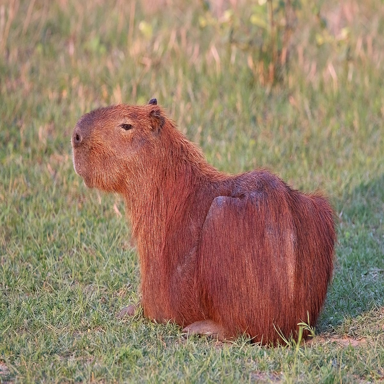

In [ ]:
top3 = outputs[0].topk(3).indices
top3 = top3.tolist()


print("Top 3 predictions:")
for class_num in top3:
    print(class_num, classes[class_num])
display(capybara_in_pil.resize((384, 384)))

Ну что ж, почти (капибар в классах ImageNet 1k, как вы могли догадаться, просто нет).

## DeiT: Data-efficient Image Transformers

Для практических задач рекомендуем использовать эту реализацию. Авторы предлагают подход, благодаря которому становится возможным обучить модель на стандартном **ImageNet** (ImageNet1k) на одной рабочей станции за 3 дня.

*We train them on a single computer in less than 3 days. Our reference vision transformer (86M parameters) achieves top-1 accuracy of 83.1% (single-crop evaluation) on ImageNet with no external data.*

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/cited_deit_vit.png"  width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2012.12877">Training data-efficient image transformers & distillation through attention</a></em></center>



Разбор этого материала уже не входит в наш курс и рекомендуется к самостоятельному изучению.

Дополнительно:
* [[arxiv] 🎓 Training data-efficient image transformers
& distillation through attention](https://arxiv.org/pdf/2012.12877v2.pdf)

Статьи, предшествовавшие появлению **ViT**:
* [[arxiv] 🎓 Non-local Neural Networks](https://arxiv.org/abs/1711.07971)
* [[arxiv] 🎓 CCNet: Criss-Cross Attention for Semantic Segmentation](https://arxiv.org/abs/1811.11721)






## Использование ViT с собственным датасетом

Для использования **ViT** с собственными данными рекомендуем не обучать собственную модель с нуля, а использовать уже предобученную.

Рассмотрим этот процесс на примере. Есть предобученный на **ImageNet** **Visual Transformer**, например: [deit_tiny_patch16_224 🐾[git]](https://github.com/facebookresearch/deit)

И мы хотим использовать ее со своим датасетом, который может сильно отличаться от **ImageNet**.

Для примера возьмем **CIFAR-10**.



Загрузим [модель 🐾[git]](https://github.com/facebookresearch/deit). Она зависит от библиотеки [timm 🛠️[doc]](https://fastai.github.io/timmdocs/), которую нужно установить.

In [ ]:
!pip install -q timm

Также можно загрузить модель с [pytorch-hub 🛠️[doc]](https://pytorch.org/hub/):


```
import torch

model = torch.hub.load(
    "facebookresearch/deit:main", "deit_tiny_patch16_224", pretrained=True
)
```



In [ ]:
model = timm.create_model(model_name="deit_base_patch16_384.fb_in1k", pretrained=True)

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Убедимся, что модель запускается.
Загрузим изображение:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/L10/capybara.jpg

И подадим его на вход трансформеру:

torch.Size([1, 1000])


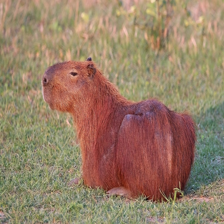

In [ ]:
import torchvision.transforms as T
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


image = Image.open("capybara.jpg")

# create the data transform that DeiT expects
imagenet_transform = T.Compose(
    [
        T.Resize((384, 384)),
        T.ToTensor(),
        T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ]
)

out = model(imagenet_transform(image).unsqueeze(0))
print(out.shape)
image.resize((224, 224))

Чтобы использовать модель с **CIFAR-10**, нужно поменять количество выходов слоя, отвечающего за классификацию, так как в **CIFAR-10** десять классов, а в **ImageNet** — тысяча.

Чтобы понять, как получить доступ к последнему слою, выведем структуру модели:


In [ ]:
model = timm.create_model(
    model_name="deit_base_patch16_384.fb_in1k", num_classes=10, pretrained=True
)

Теперь загрузим **CIFAR-10** и проверим, как дообучится модель.

In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

cifar10 = CIFAR10(root="./", train=True, download=True, transform=imagenet_transform)

# We use only part of CIFAR10 to reduce training time
trainset, valset, _ = torch.utils.data.random_split(cifar10, [4000, 1000, 45000])
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

testset = CIFAR10(root="./", train=False, download=True, transform=imagenet_transform)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 41758075.59it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


 Проведем стандартный цикл обучения.

In [ ]:
!pip install -q lightning

In [ ]:
import lightning as L
from torch import nn
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        num_classes=10,
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
        optimizer_target=model.parameters(),
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs
        self.optimizer_target = optimizer_target
        metrics = MetricCollection([MulticlassAccuracy(num_classes=num_classes)])
        self.train_metrics = metrics.clone(postfix="/train")
        self.valid_metrics = metrics.clone(postfix="/val")
        self.test_metrics = metrics.clone(postfix="/test")

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.optimizer_target, **self.optimizer_kwargs)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)

        self.log("Loss/train", loss, prog_bar=True)
        self.train_metrics.update(out, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("Loss/val", loss, prog_bar=True)
        self.valid_metrics.update(out, y)

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.test_metrics.update(out, y)

    def on_training_epoch_end(self):
        train_metrics = self.train_metrics.compute()
        self.log_dict(train_metrics)
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        valid_metrics = self.valid_metrics.compute()
        self.log_dict(valid_metrics)
        self.valid_metrics.reset()

    def on_test_epoch_end(self):
        test_metrics = self.test_metrics.compute()
        self.log_dict(test_metrics)
        self.test_metrics.reset()

Дообучаем (**fine tune**) только последний слой модели, который мы изменили.

In [ ]:
import torch.optim as optim

from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from warnings import simplefilter

simplefilter("ignore", RuntimeWarning)

checkpoint_callback = ModelCheckpoint(
    monitor="MulticlassAccuracy/val", mode="max", filename="best"
)

exp_name = "deit_base_patch16_384_finetune"
trainer = Trainer(
    max_epochs=1,
    logger=TensorBoardLogger(save_dir=f"logs/L10", name=exp_name),
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback],
)

pipeline = Pipeline(
    model=model,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs={"lr": 0.0001},
    optimizer_target=model.head.parameters(),
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type              | Params
----------------------------------------------------
0 | model         | VisionTransformer | 86.1 M
1 | criterion     | CrossEntropyLoss  | 0     
2 | train_metrics | MetricCollection  | 0     
3 | valid_metrics | MetricCollection  | 0     
4 | test_metrics  | MetricCollection  | 0     
---------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Проверим точность на всей тестовой подвыборке **CIFAR-10**.

In [ ]:
trainer.test(model=pipeline, dataloaders=test_loader, ckpt_path="best")

INFO: Restoring states from the checkpoint path at logs/L10/deit_base_patch16_384_finetune/version_0/checkpoints/best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at logs/L10/deit_base_patch16_384_finetune/version_0/checkpoints/best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at logs/L10/deit_base_patch16_384_finetune/version_0/checkpoints/best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at logs/L10/deit_base_patch16_384_finetune/version_0/checkpoints/best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/test  │    0.7562999725341797     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy/test': 0.7562999725341797}]

Дообучив последний слой на одной эпохе с использованием 20% данных, мы получили точность ~0.75

Если дообучить все слои на 2-х эпохах, можно получить точность порядка 0.95.

Это результат намного лучше, чем тот, что мы получали на семинарах.

Для этого потребуется порядка 10 мин (на GPU). Сейчас мы этого делать не будем.


И одной из причин того, что обучение идет относительно медленно, является увеличение изображений размером 32×32 до 224×224.

Если бы мы использовали изображения **CIFAR-10** в их родном размере, мы бы не потеряли никакой информации, но могли бы в разы ускорить обучение.


<font size = "6">Литература</font>

<font size = "5">Трансформеры:</font>

* [[blog] ✏️ Про трансформеры](https://arig23498.notion.site/Transformers-969f4b27c48147778c1e2dbda0c83ce0)
* [[blog] ✏️ Аннотированный трансформер](http://nlp.seas.harvard.edu/2018/04/03/attention.html)
* [[blog] ✏️ Код множества моделей с красивыми комментариями](https://nn.labml.ai/)
* [[blog] ✏️ Зоопарк Трансформеров: большой обзор моделей от BERT до Alpaca](https://habr.com/ru/companies/just_ai/articles/733110/)
* [[blog] ✏️ Transformers in computer vision: ViT architectures, tips, tricks and improvements](https://theaisummer.com/transformers-computer-vision/)
* [[blog] ✏️ Illustrated transformer](https://jalammar.github.io/illustrated-transformer/)
* [[blog] ✏️ Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)
* [[blog] ✏️ Open-source реализация GPT-3](https://arankomatsuzaki.wordpress.com/2021/06/04/gpt-j/)
* [[git] 🐾 Transformer для русского языка](https://github.com/vlarine/transformers-ru)
* [[blog] ✏️ NLP Course for you](https://lena-voita.github.io/nlp_course.html)
* [[git] 🐾 Курс по NLP от ШАД](https://github.com/yandexdataschool/nlp_course)

<font size = "5">Оригинальные статьи про поколения GPT:</font>
* [[blog] ✏️ Improving Language Understanding by Generative Pre-Training (2018)](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)
* [[blog] ✏️ Language Models are Unsupervised Multitask Learners (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
* [[arxiv] 🎓 Language Models are Few-Shot Learners (2020)](https://arxiv.org/pdf/2005.14165.pdf)

<font size = "5">Полезные ссылки:</font>
* [[blog] ✏️ GPT в картинках](https://habr.com/ru/post/490842/) — очень подробный разбор внутренней архитектуры GPT-2 с акцентом на иллюстрации
* [[blog] ✏️ Трансформер в картинках](https://habr.com/ru/post/486358/) — очень подробный разбор архитектуры Transformer с акцентом на иллюстрации
* [[doc] 🛠️ Tokenizers tutorial](https://huggingface.co/docs/transformers/tokenizer_summary) — краткий разбор всех типов токенизаторов от Huggingface с примерами
* [[doc] 🛠️ Как генерировать текст](https://huggingface.co/blog/how-to-generate) — обзор способов сэмплирования текста с помощью языковых моделей (бимсёрч и тд)
* [[arxiv] 🎓 Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) — оригинальная статья про первый трансформер
* [[blog] ✏️ GPT-1](https://openai.com/blog/language-unsupervised/) — статья в блоге OpenAI про GPT-1
* [[blog] ✏️ GPT-2](https://openai.com/blog/better-language-models/) — статья в блоге OpenAI про GPT-2
* [[blog] ✏️ GPT-3](https://openai.com/blog/gpt-3-apps/) — статья в блоге OpenAI про GPT-3
* [[blog] ✏️ WebGPT](https://openai.com/blog/improving-factual-accuracy/) — статья в блоге OpenAI про GPT-3, обученную гуглить
* [[blog] ✏️ Codex](https://openai.com/blog/openai-codex/) — статья в блоге OpenAI про GPT-3, обученную писать код
* [[blog] ✏️ Как устроен  self-attention](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html)
* [[doc] 🛠️ Self-attention слой в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)